In [1]:
# Install required packages
!pip install -q aws-cdk-lib boto3 pandas matplotlib
!npm install -g aws-cdk  # Make sure CDK CLI is installed

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.2 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.3 which is incompatible.
ydata-profiling 4.12.2 requires pydantic>=2, but you have pydantic 1.10.21 which is incompatible.
ydata-profiling 4.12.2 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
added 1 package in 5s
⠴npm notice
npm notice New major version of npm available! 10.7.0 -> 11.2.0
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.2.0
npm notice To update run: npm install -g npm@11.2.0
npm notice
⠴

In [11]:
%%writefile app.py
from aws_cdk import (
    App,
    Stack,
    Duration,
    aws_s3 as s3,
    aws_lambda as lambda_,
    aws_lambda_event_sources as lambda_events,
    aws_cloudwatch as cloudwatch,
    aws_cloudwatch_actions as cw_actions,
    aws_sns as sns,
    aws_iam as iam,
    RemovalPolicy,
    CfnOutput
)
from constructs import Construct
import os

class DataQualityPipelineStack(Stack):
    def __init__(self, scope: Construct, construct_id: str, **kwargs) -> None:
        super().__init__(scope, construct_id, **kwargs)
        
        # Create S3 buckets
        self.raw_bucket = s3.Bucket(
            self, "RawDataBucket",
            removal_policy=RemovalPolicy.DESTROY,  # For demonstration - use RETAIN in production
            auto_delete_objects=True               # For demonstration - remove in production
        )
        
        self.validated_bucket = s3.Bucket(
            self, "ValidatedDataBucket",
            removal_policy=RemovalPolicy.DESTROY,  # For demonstration - use RETAIN in production
            auto_delete_objects=True               # For demonstration - remove in production
        )
        # Add outputs
        CfnOutput(self, "RawDataBucketOutput",
            value=self.raw_bucket.bucket_name,
            description="Raw data bucket name"
        )
        
        CfnOutput(self, "ValidatedDataBucketOutput",
            value=self.validated_bucket.bucket_name,
            description="Validated data bucket name"
        )
        
        CfnOutput(self, "QualityDashboardURLOutput",
            value=f"https://console.aws.amazon.com/cloudwatch/home#dashboards:name=DataQualityDashboard",
            description="URL for the CloudWatch dashboard"
        )
        
        # Create SNS topic for alerts
        self.alert_topic = sns.Topic(
            self, "QualityAlertsTopic",
            display_name="Data Quality Alerts"
        )
        
        # Create Lambda function for validation
        self.validator = lambda_.Function(
            self, "TransactionValidator",
            runtime=lambda_.Runtime.PYTHON_3_9,
            handler="index.handler",
            code=lambda_.Code.from_inline(self.get_validation_code()),
            timeout=Duration.minutes(5),
            memory_size=512,
            environment={
                "VALIDATED_BUCKET": self.validated_bucket.bucket_name,
                "ALERT_TOPIC": self.alert_topic.topic_arn
            }
        )
        
        # Grant Lambda permissions
        self.raw_bucket.grant_read(self.validator)
        self.validated_bucket.grant_write(self.validator)
        self.alert_topic.grant_publish(self.validator)
        
        # Add CloudWatch permissions to Lambda role
        self.validator.add_to_role_policy(
            iam.PolicyStatement(
                actions=["cloudwatch:PutMetricData"],
                resources=["*"]
            )
        )
        
        # Add S3 trigger for Lambda
        self.validator.add_event_source(
            lambda_events.S3EventSource(
                self.raw_bucket,
                events=[s3.EventType.OBJECT_CREATED],
                filters=[s3.NotificationKeyFilter(prefix="transactions/")]
            )
        )
        
        # Create CloudWatch dashboard
        dashboard = cloudwatch.Dashboard(
            self, "QualityDashboard",
            dashboard_name="DataQualityDashboard"
        )
        
        # Add dashboard widgets
        dashboard.add_widgets(
            cloudwatch.GraphWidget(
                title="Overall Quality Score",
                left=[
                    cloudwatch.Metric(
                        namespace="DataQuality",
                        metric_name="QualityScore",
                        dimensions_map={"Dataset": "Transactions"},
                        statistic="Average",
                        period=Duration.minutes(5)
                    )
                ],
                width=12,
                height=6
            ),
            cloudwatch.GraphWidget(
                title="Valid Records Percentage",
                left=[
                    cloudwatch.Metric(
                        namespace="DataQuality",
                        metric_name="ValidRecords",
                        dimensions_map={"Dataset": "Transactions"},
                        statistic="Average",
                        period=Duration.minutes(5)
                    )
                ],
                width=12,
                height=6
            )
        )
        
        dashboard.add_widgets(
            cloudwatch.GraphWidget(
                title="Error Percentages by Type",
                left=[
                    cloudwatch.Metric(
                        namespace="DataQuality",
                        metric_name="missing_customer_id",
                        dimensions_map={"Dataset": "Transactions"},
                        statistic="Average",
                        period=Duration.minutes(5)
                    ),
                    cloudwatch.Metric(
                        namespace="DataQuality",
                        metric_name="negative_amount",
                        dimensions_map={"Dataset": "Transactions"},
                        statistic="Average",
                        period=Duration.minutes(5)
                    ),
                    cloudwatch.Metric(
                        namespace="DataQuality",
                        metric_name="invalid_timestamp",
                        dimensions_map={"Dataset": "Transactions"},
                        statistic="Average",
                        period=Duration.minutes(5)
                    ),
                    cloudwatch.Metric(
                        namespace="DataQuality",
                        metric_name="invalid_payment_method",
                        dimensions_map={"Dataset": "Transactions"},
                        statistic="Average",
                        period=Duration.minutes(5)
                    )
                ],
                width=24,
                height=6
            )
        )
        
        # Create CloudWatch alarm
        quality_alarm = cloudwatch.Alarm(
            self, "QualityScoreAlarm",
            metric=cloudwatch.Metric(
                namespace="DataQuality",
                metric_name="QualityScore",
                dimensions_map={"Dataset": "Transactions"},
                statistic="Average",
                period=Duration.minutes(5)
            ),
            threshold=85,
            comparison_operator=cloudwatch.ComparisonOperator.LESS_THAN_THRESHOLD,
            evaluation_periods=1,
            alarm_description="Data quality score below threshold"
        )
        
        # Connect alarm to SNS topic
        quality_alarm.add_alarm_action(
            cw_actions.SnsAction(self.alert_topic)
        )
    
    def get_validation_code(self):
        """Return Python code for Lambda validation function"""
        return """
import json
import boto3
import os
import datetime

# Initialize clients
s3 = boto3.client('s3')
cloudwatch = boto3.client('cloudwatch')
sns = boto3.client('sns')

# Get environment variables
validated_bucket = os.environ['VALIDATED_BUCKET']
alert_topic = os.environ['ALERT_TOPIC']

def handler(event, context):
    # Get the S3 object information
    bucket = event['Records'][0]['s3']['bucket']['name']
    key = event['Records'][0]['s3']['object']['key']
    
    try:
        # Get the object from S3
        response = s3.get_object(Bucket=bucket, Key=key)
        content = response['Body'].read().decode('utf-8')
        transactions = json.loads(content)
        
        # Initialize validation results
        validation_metrics = {
            'missing_customer_id': 0,
            'negative_amount': 0,
            'invalid_timestamp': 0,
            'invalid_payment_method': 0
        }
        
        # Track valid and invalid records
        valid_records = []
        invalid_records = []
        
        # Process each transaction
        for transaction in transactions:
            errors = []
            
            # Check for required customer_id
            if 'customer_id' not in transaction or not transaction['customer_id']:
                errors.append('missing_customer_id')
                validation_metrics['missing_customer_id'] += 1
            
            # Check for negative amounts
            if 'amount' in transaction and float(transaction['amount']) < 0:
                errors.append('negative_amount')
                validation_metrics['negative_amount'] += 1
            
            # Check timestamp format
            if 'timestamp' in transaction:
                try:
                    datetime.datetime.strptime(transaction['timestamp'], '%Y-%m-%d %H:%M:%S')
                except ValueError:
                    errors.append('invalid_timestamp')
                    validation_metrics['invalid_timestamp'] += 1
            
            # Check payment method is valid
            valid_methods = ['CREDIT', 'DEBIT', 'PAYPAL', 'GIFT_CARD']
            if 'payment_method' in transaction and transaction['payment_method'] not in valid_methods:
                errors.append('invalid_payment_method')
                validation_metrics['invalid_payment_method'] += 1
            
            # Store transaction in appropriate list
            if errors:
                transaction['validation_errors'] = errors
                invalid_records.append(transaction)
            else:
                valid_records.append(transaction)
        
        # Calculate total and passing percentages
        total_records = len(transactions)
        valid_percentage = (len(valid_records) / total_records) * 100 if total_records > 0 else 0
        
        # Log validation results
        print(f"Processed {total_records} records")
        print(f"Valid: {len(valid_records)} ({valid_percentage:.2f}%)")
        print(f"Invalid: {len(invalid_records)} ({100-valid_percentage:.2f}%)")
        
        # Publish metrics to CloudWatch
        metric_data = []
        
        # Overall metrics
        metric_data.append({
            'MetricName': 'ValidRecords',
            'Value': valid_percentage,
            'Unit': 'Percent',
            'Dimensions': [{'Name': 'Dataset', 'Value': 'Transactions'}]
        })
        
        # Error type metrics
        for error_type, count in validation_metrics.items():
            error_pct = (count / total_records) * 100 if total_records > 0 else 0
            metric_data.append({
                'MetricName': error_type,
                'Value': error_pct,
                'Unit': 'Percent',
                'Dimensions': [{'Name': 'Dataset', 'Value': 'Transactions'}]
            })
        
        # Calculate quality score (100 - average error percentage)
        error_types = len(validation_metrics)
        if error_types > 0 and total_records > 0:
            quality_score = 100 - sum([
                (validation_metrics[m] / total_records) * 100 
                for m in validation_metrics
            ]) / error_types
        else:
            quality_score = 100
        
        metric_data.append({
            'MetricName': 'QualityScore',
            'Value': quality_score,
            'Unit': 'None',
            'Dimensions': [{'Name': 'Dataset', 'Value': 'Transactions'}]
        })
        
        cloudwatch.put_metric_data(
            Namespace='DataQuality',
            MetricData=metric_data
        )
        
        # Save validated and invalid records
        if valid_records:
            output_key = key.replace('transactions/', 'validated/')
            s3.put_object(
                Bucket=validated_bucket,
                Key=output_key,
                Body=json.dumps(valid_records)
            )
            print(f"Saved {len(valid_records)} valid records to validated bucket")
        
        if invalid_records:
            error_key = key.replace('transactions/', 'errors/')
            s3.put_object(
                Bucket=validated_bucket,
                Key=error_key,
                Body=json.dumps(invalid_records)
            )
            print(f"Saved {len(invalid_records)} invalid records to error folder")
        
        # Alert if quality is poor
        if quality_score < 85:
            sns.publish(
                TopicArn=alert_topic,
                Subject=f"Low data quality score: {quality_score:.2f}",
                Message=json.dumps({
                    'quality_score': quality_score,
                    'file': f"s3://{bucket}/{key}",
                    'validation_metrics': validation_metrics,
                    'timestamp': datetime.datetime.now().isoformat()
                })
            )
        
        return {
            'statusCode': 200,
            'body': json.dumps({
                'quality_score': quality_score,
                'valid_records': len(valid_records),
                'invalid_records': len(invalid_records)
            })
        }
        
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        sns.publish(
            TopicArn=alert_topic,
            Subject="Error in data validation",
            Message=f"Error processing s3://{bucket}/{key}: {str(e)}"
        )
        return {
            'statusCode': 500,
            'body': json.dumps({
                'error': str(e)
            })
        }
"""

# Create the CDK app
app = App()
DataQualityPipelineStack(app, "DataQualityPipeline")
app.synth()

Overwriting app.py


In [ ]:
# Deploy the CDK stack; alternatively run it form command line.

!cdk deploy --require-approval never --app "python app.py"

In [14]:
import boto3
import json
import os

def get_stack_outputs():
    try:
        cloudformation = boto3.client('cloudformation')
        response = cloudformation.describe_stacks(StackName='DataQualityPipeline')
        
        # Print raw response for debugging
        print("Raw CloudFormation response:")
        print(json.dumps(response, default=str, indent=2))
        
        if 'Stacks' in response and len(response['Stacks']) > 0:
            stack = response['Stacks'][0]
            if 'Outputs' in stack:
                outputs = {output['OutputKey']: output['OutputValue'] 
                         for output in stack['Outputs']}
                
                # Print available outputs for debugging
                print("\nAvailable outputs:")
                for key, value in outputs.items():
                    print(f"{key}: {value}")
                    
                return outputs
            else:
                print("Stack has no outputs")
                return {}
    except Exception as e:
        print(f"Error getting stack outputs: {e}")
        return {}

# Get stack outputs
outputs = get_stack_outputs()

if outputs:
    try:
        # Save bucket names to environment variables using get() with default values
        os.environ['RAW_BUCKET'] = outputs.get('RawDataBucketOutput', '')
        os.environ['VALIDATED_BUCKET'] = outputs.get('ValidatedDataBucketOutput', '')

        # Print outputs using safe get() method
        print("\nStack Outputs:")
        print(f"Raw data bucket: {outputs.get('RawDataBucketOutput', 'Not found')}")
        print(f"Validated data bucket: {outputs.get('ValidatedDataBucketOutput', 'Not found')}")
        print(f"CloudWatch dashboard: {outputs.get('QualityDashboardOutput', 'Not found')}")

    except KeyError as e:
        print(f"Error accessing output: {e}")
        print("Available keys:", list(outputs.keys()))
else:
    print("No outputs available from the stack")


Raw CloudFormation response:
{
  "Stacks": [
    {
      "StackId": "arn:aws:cloudformation:ap-south-1:359373501475:stack/DataQualityPipeline/22cb1720-02fa-11f0-9395-06d9cbf2d617",
      "StackName": "DataQualityPipeline",
      "ChangeSetId": "arn:aws:cloudformation:ap-south-1:359373501475:changeSet/cdk-deploy-change-set/8ffa1012-d01a-4ffa-8f16-4d9971258951",
      "Parameters": [
        {
          "ParameterKey": "BootstrapVersion",
          "ParameterValue": "/cdk-bootstrap/hnb659fds/version",
          "ResolvedValue": "23"
        }
      ],
      "CreationTime": "2025-03-17 06:36:19.969000+00:00",
      "LastUpdatedTime": "2025-03-17 06:36:25.572000+00:00",
      "RollbackConfiguration": {},
      "StackStatus": "CREATE_COMPLETE",
      "DisableRollback": false,
      "NotificationARNs": [],
      "Capabilities": [
        "CAPABILITY_IAM",
        "CAPABILITY_NAMED_IAM",
        "CAPABILITY_AUTO_EXPAND"
      ],
      "Outputs": [
        {
          "OutputKey": "ValidatedDa

In [15]:
# Generate sample transaction data with quality issues
import json
import random
from datetime import datetime, timedelta
import boto3

# Generate synthetic transactions
def generate_sample_data(count=100):
    transactions = []
    for i in range(count):
        # Insert occasional errors
        has_customer_id = random.random() > 0.05
        has_valid_amount = random.random() > 0.08
        has_valid_timestamp = random.random() > 0.07
        has_valid_method = random.random() > 0.06
        
        transaction = {
            "transaction_id": f"TXN-{i:06d}",
            "amount": random.randint(1, 1000) if has_valid_amount else -random.randint(1, 100)
        }
        
        if has_customer_id:
            transaction["customer_id"] = f"CUST-{random.randint(1000, 9999)}"
        
        if has_valid_timestamp:
            date = datetime.now() - timedelta(days=random.randint(0, 30))
            transaction["timestamp"] = date.strftime('%Y-%m-%d %H:%M:%S')
        else:
            transaction["timestamp"] = "invalid-date"
        
        if has_valid_method:
            transaction["payment_method"] = random.choice(['CREDIT', 'DEBIT', 'PAYPAL', 'GIFT_CARD'])
        else:
            transaction["payment_method"] = f"UNKNOWN-{random.randint(1, 100)}"
        
        transactions.append(transaction)
    
    return transactions

# Generate and upload data
transactions = generate_sample_data(200)
s3 = boto3.client('s3')
s3.put_object(
    Bucket=os.environ['RAW_BUCKET'],
    Key='transactions/sample_batch.json',
    Body=json.dumps(transactions)
)

print(f"Uploaded 200 sample transactions to s3://{os.environ['RAW_BUCKET']}/transactions/sample_batch.json")

Uploaded 200 sample transactions to s3://dataqualitypipeline-rawdatabucket57f26c03-jh4eiqpjmqew/transactions/sample_batch.json


In [16]:
# Wait a moment for Lambda to process the file
import time
print("Waiting for Lambda function to process data...")
time.sleep(10)

# Check Lambda logs
import boto3
logs = boto3.client('logs')

# Get the Lambda function name
lambda_client = boto3.client('lambda')
functions = lambda_client.list_functions()
validator_function = next(f for f in functions['Functions'] if 'TransactionValidator' in f['FunctionName'])
function_name = validator_function['FunctionName']

# Get log group name
log_group_name = f"/aws/lambda/{function_name}"

# Get log streams
log_streams = logs.describe_log_streams(
    logGroupName=log_group_name,
    orderBy='LastEventTime',
    descending=True,
    limit=1
)

if log_streams['logStreams']:
    stream_name = log_streams['logStreams'][0]['logStreamName']
    
    # Get log events
    log_events = logs.get_log_events(
        logGroupName=log_group_name,
        logStreamName=stream_name,
        limit=30
    )
    
    print(f"Recent logs from {function_name}:")
    for event in log_events['events']:
        print(event['message'])
else:
    print(f"No log streams found for {function_name}")

Waiting for Lambda function to process data...
Recent logs from DataQualityPipeline-TransactionValidator0ECD65AF-1vdr4OkcRpQ3:
INIT_START Runtime Version: python:3.9.v82	Runtime Version ARN: arn:aws:lambda:ap-south-1::runtime:d6dc717114b06da7d4b5a2df328222709ec4fad2853004fac301b8b63a65c084

START RequestId: f13d9aee-b73b-4ea0-a5a7-7bef858e1c2d Version: $LATEST

Processed 200 records

Valid: 156 (78.00%)

Invalid: 44 (22.00%)

Saved 156 valid records to validated bucket

Saved 44 invalid records to error folder

END RequestId: f13d9aee-b73b-4ea0-a5a7-7bef858e1c2d

REPORT RequestId: f13d9aee-b73b-4ea0-a5a7-7bef858e1c2d	Duration: 247.70 ms	Billed Duration: 248 ms	Memory Size: 512 MB	Max Memory Used: 87 MB	Init Duration: 500.21 ms	



In [17]:
# Check for validated and error records in the output bucket
import boto3
import json

s3 = boto3.client('s3')

# List objects in the validated folder
try:
    validated_objects = s3.list_objects_v2(
        Bucket=os.environ['VALIDATED_BUCKET'],
        Prefix='validated/'
    )
    
    if 'Contents' in validated_objects:
        # Get the first validated file
        validated_key = validated_objects['Contents'][0]['Key']
        response = s3.get_object(Bucket=os.environ['VALIDATED_BUCKET'], Key=validated_key)
        validated_data = json.loads(response['Body'].read().decode('utf-8'))
        
        print(f"Found {len(validated_data)} valid records")
        print("\nSample valid record:")
        print(json.dumps(validated_data[0], indent=2))
except Exception as e:
    print(f"Error checking validated data: {str(e)}")

# List objects in the errors folder
try:
    error_objects = s3.list_objects_v2(
        Bucket=os.environ['VALIDATED_BUCKET'],
        Prefix='errors/'
    )
    
    if 'Contents' in error_objects:
        # Get the first error file
        error_key = error_objects['Contents'][0]['Key']
        response = s3.get_object(Bucket=os.environ['VALIDATED_BUCKET'], Key=error_key)
        error_data = json.loads(response['Body'].read().decode('utf-8'))
        
        print(f"\nFound {len(error_data)} invalid records")
        print("\nSample invalid record with errors:")
        print(json.dumps(error_data[0], indent=2))
except Exception as e:
    print(f"Error checking error data: {str(e)}")

Found 156 valid records

Sample valid record:
{
  "transaction_id": "TXN-000001",
  "amount": 955,
  "customer_id": "CUST-8387",
  "timestamp": "2025-03-11 12:34:23",
  "payment_method": "GIFT_CARD"
}

Found 44 invalid records

Sample invalid record with errors:
{
  "transaction_id": "TXN-000000",
  "amount": 868,
  "timestamp": "2025-02-21 12:34:23",
  "payment_method": "PAYPAL",
  "validation_errors": [
    "missing_customer_id"
  ]
}


/Users/sanjij/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


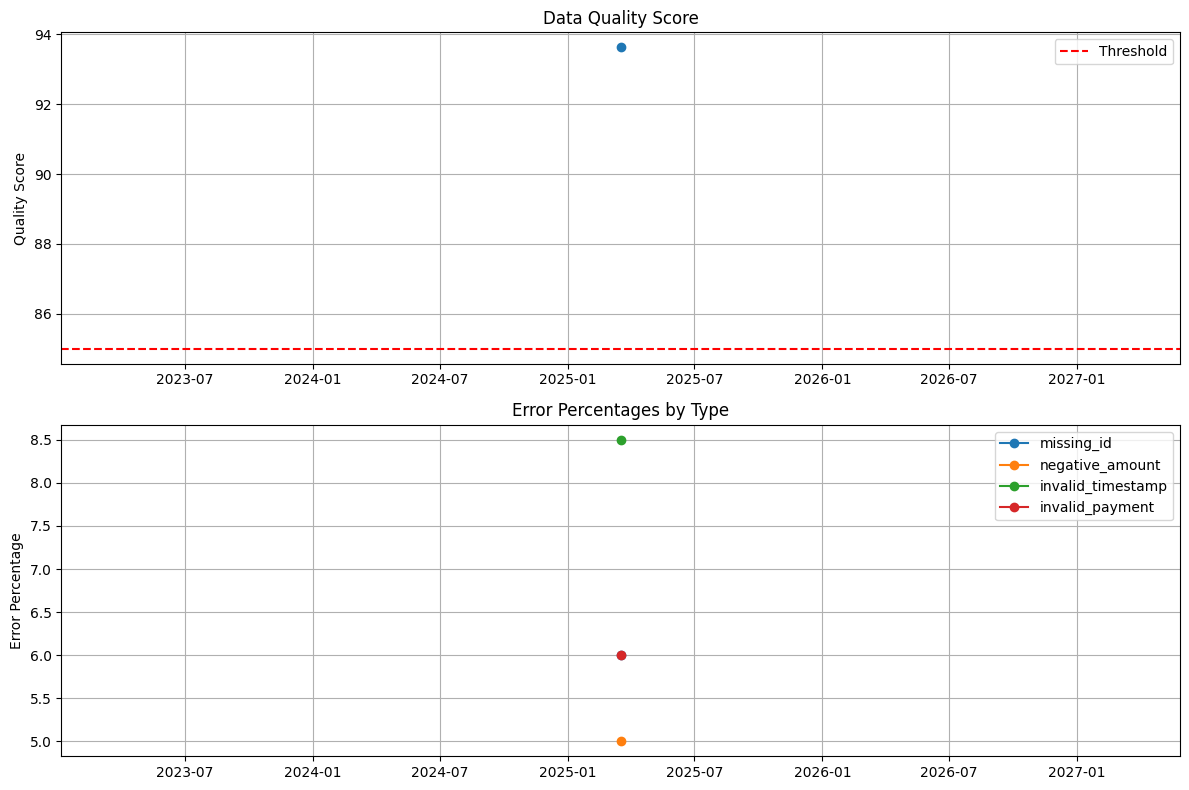

To view the complete dashboard in AWS Console:
1. Navigate to CloudWatch service in AWS Console
2. Select 'Dashboards' from the left navigation panel
3. Click on 'DataQualityDashboard'


In [1]:
# Fetch CloudWatch metrics for visualization
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

cloudwatch = boto3.client('cloudwatch')

# Get metrics for the last hour
end_time = datetime.utcnow()
start_time = end_time - timedelta(hours=1)

# Get quality score
quality_score = cloudwatch.get_metric_data(
    MetricDataQueries=[
        {
            'Id': 'quality',
            'MetricStat': {
                'Metric': {
                    'Namespace': 'DataQuality',
                    'MetricName': 'QualityScore',
                    'Dimensions': [
                        {
                            'Name': 'Dataset',
                            'Value': 'Transactions'
                        }
                    ]
                },
                'Period': 300,
                'Stat': 'Average'
            }
        }
    ],
    StartTime=start_time,
    EndTime=end_time
)

# Get error metrics
error_metrics = cloudwatch.get_metric_data(
    MetricDataQueries=[
        {
            'Id': 'missing_id',
            'MetricStat': {
                'Metric': {
                    'Namespace': 'DataQuality',
                    'MetricName': 'missing_customer_id',
                    'Dimensions': [
                        {
                            'Name': 'Dataset',
                            'Value': 'Transactions'
                        }
                    ]
                },
                'Period': 300,
                'Stat': 'Average'
            }
        },
        {
            'Id': 'negative_amount',
            'MetricStat': {
                'Metric': {
                    'Namespace': 'DataQuality',
                    'MetricName': 'negative_amount',
                    'Dimensions': [
                        {
                            'Name': 'Dataset',
                            'Value': 'Transactions'
                        }
                    ]
                },
                'Period': 300,
                'Stat': 'Average'
            }
        },
        {
            'Id': 'invalid_timestamp',
            'MetricStat': {
                'Metric': {
                    'Namespace': 'DataQuality',
                    'MetricName': 'invalid_timestamp',
                    'Dimensions': [
                        {
                            'Name': 'Dataset',
                            'Value': 'Transactions'
                        }
                    ]
                },
                'Period': 300,
                'Stat': 'Average'
            }
        },
        {
            'Id': 'invalid_payment',
            'MetricStat': {
                'Metric': {
                    'Namespace': 'DataQuality',
                    'MetricName': 'invalid_payment_method',
                    'Dimensions': [
                        {
                            'Name': 'Dataset',
                            'Value': 'Transactions'
                        }
                    ]
                },
                'Period': 300,
                'Stat': 'Average'
            }
        }
    ],
    StartTime=start_time,
    EndTime=end_time
)

# Create visualization
plt.figure(figsize=(12, 8))

# Plot quality score if data exists
if quality_score['MetricDataResults'][0]['Values']:
    plt.subplot(2, 1, 1)
    plt.title('Data Quality Score')
    plt.plot(
        quality_score['MetricDataResults'][0]['Timestamps'],
        quality_score['MetricDataResults'][0]['Values'],
        marker='o',
        linestyle='-',
        linewidth=2
    )
    plt.axhline(y=85, color='r', linestyle='--', label='Threshold')
    plt.grid(True)
    plt.legend()
    plt.ylabel('Quality Score')

# Plot error metrics if data exists
if any(result['Values'] for result in error_metrics['MetricDataResults']):
    plt.subplot(2, 1, 2)
    plt.title('Error Percentages by Type')
    
    # Only plot if there are values
    for result in error_metrics['MetricDataResults']:
        if result['Values']:
            plt.plot(
                result['Timestamps'],
                result['Values'],
                marker='o',
                linestyle='-',
                label=result['Id']
            )
    
    plt.grid(True)
    plt.legend()
    plt.ylabel('Error Percentage')

plt.tight_layout()
plt.show()

print("To view the complete dashboard in AWS Console:")
print("1. Navigate to CloudWatch service in AWS Console")
print("2. Select 'Dashboards' from the left navigation panel")
print("3. Click on 'DataQualityDashboard'")

In [ ]:
# Destroy the CDK stack to clean up resources
# Uncomment and run this cell when you're done

print("Cleaning up resources...")
!cdk destroy --force --app "python app.py"